### Visualise Region Specific Results

In [1]:
# @title
# Import neccesary libraries

#Basics
import pandas as pd
import numpy as np
from collections import Counter

#Basic Visualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from pandas.plotting import autocorrelation_plot

#Autocorrelations and Stationarity
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller

#Map Vis
import geopandas as gpd
import requests, zipfile, io, os
import matplotlib.patches as mpatches

In [2]:
# @title
#PREP

# ----------------------------
# 1. Download your GitHub repo ZIP
# ----------------------------
zip_url = "https://raw.githubusercontent.com/richardneureuther/DLSS_RNN_Project/main/Data/Shapefiles/tl_2024_us_cbsa.zip"
r = requests.get(zip_url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# Extract all files into a folder
extract_folder = "repo_downloaded"
z.extractall(extract_folder)

# ----------------------------
# 2. Automatically find the .shp file
# ----------------------------
shp_file = None
for root, dirs, files in os.walk(extract_folder):
    for file in files:
        if file.endswith(".shp"):
            shp_file = os.path.join(root, file)
            break
    if shp_file:
        break

if shp_file is None:
    raise FileNotFoundError("No .shp file found in the extracted ZIP.")

print(f"Found shapefile at: {shp_file}")

# ----------------------------
# 3. Load shapefile with GeoPandas
# ----------------------------
cbsa_shapes = gpd.read_file(shp_file)

Found shapefile at: repo_downloaded/tl_2024_us_cbsa.shp


#### GRU for Income per Capita (only Expenditure)

In [3]:
# @title
#load csv from github
GRU_income_exp = pd.read_csv("https://raw.githubusercontent.com/richardneureuther/DLSS_RNN_Project/main/Data/Final/Results/cbsa_errors_income_GRU_only_expenditure.csv")
GRU_income_exp["CBSA_Code"] = GRU_income_exp["CBSA_Code"].astype(str)
GRU_income_exp["mape_model"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).to_frame().T.round(2) #to show percentiles

,count,mean,std,min,5%,25%,50%,75%,95%,max
mape_model,2610.0,8.38,4.74,0.02,1.44,5.23,8.12,10.92,16.09,39.96


In [4]:
# @title
# CBSAs to drop (Alaska & Hawaii)
drop_cbsa_codes = ["21820", "46520", "27940", "28540", "11260"] #all CBSAs from Hawaii and Alaska

# Drop them from GRU_income_exp
GRU_income_exp = GRU_income_exp[~GRU_income_exp["CBSA_Code"].astype(str).isin(drop_cbsa_codes)]


In [5]:
# @title
#merge with shapefile
merged = cbsa_shapes.merge(GRU_income_exp, left_on="GEOID", right_on="CBSA_Code")

#filter to continental US already done by cbsa dropping

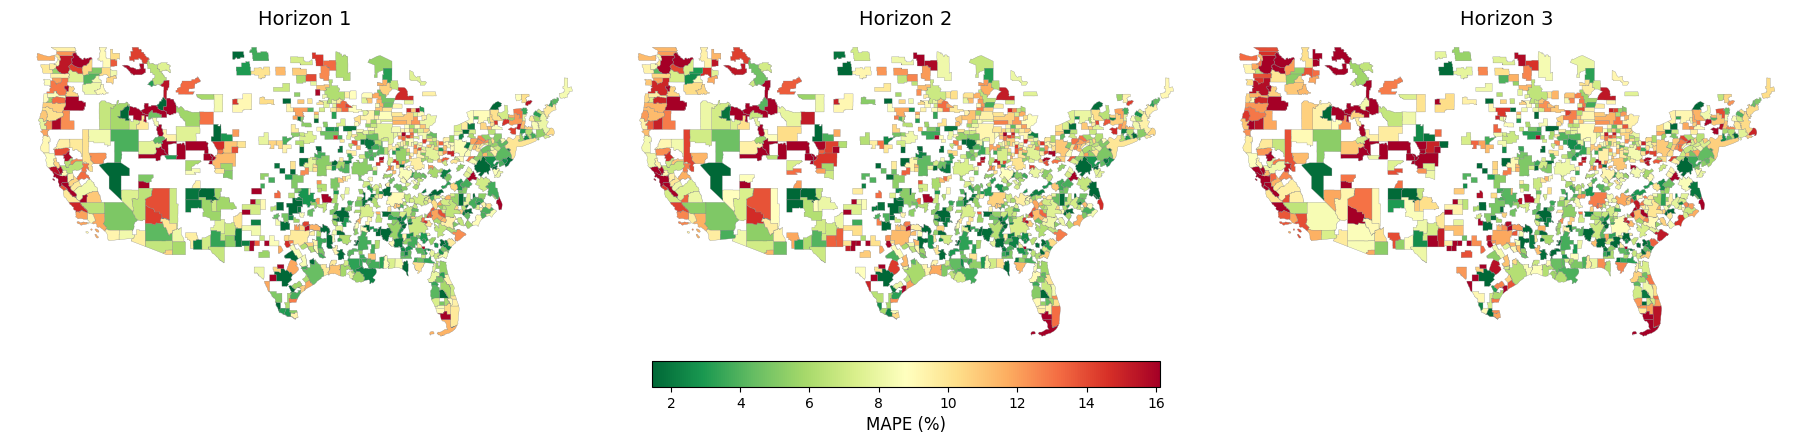

In [ ]:
# @title
# Horizons to plot
horizons = [1, 2, 3]

# Get global vmin/vmax for consistent scale across horizons
vmin = merged["mape_model"].quantile(0.05)
vmax = merged["mape_model"].quantile(0.95)

# Plot
fig, axes = plt.subplots(1, len(horizons), figsize=(18, 6), constrained_layout=True)

for i, h in enumerate(horizons):
    ax = axes[i]
    merged[merged["horizon"] == h].plot(
        column="mape_model",
        cmap="RdYlGn_r",
        linewidth=0.2,
        edgecolor="grey",
        legend=False,
        ax=ax,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"Horizon {h}", fontsize=14)
    ax.axis("off")

# Shared colorbar
sm = plt.cm.ScalarMappable(cmap="RdYlGn_r", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=axes, orientation="horizontal", fraction=0.05, pad=0.02)
cbar.set_label("MAPE (%)", fontsize=12)

# Save high-res image
plt.savefig("mape_maps_GRU_income.png", dpi=600, bbox_inches="tight")
plt.show()


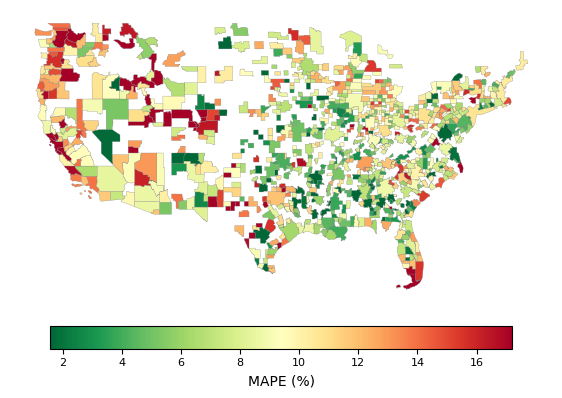

In [11]:
# @title
# Horizon 3 only for REPORT
h = 3

# Filter data
subset_h3 = merged[merged["horizon"] == h]

# vmin/vmax based on horizon 3 MAPE percentiles
vmin_h3 = subset_h3["mape_model"].quantile(0.05)
vmax_h3 = subset_h3["mape_model"].quantile(0.95)

# Plot
fig, ax = plt.subplots(figsize=(7, 6))

subset_h3.plot(
    column="mape_model",
    cmap="RdYlGn_r",
    linewidth=0.2,
    edgecolor="grey",
    legend=False,
    ax=ax,
    vmin=vmin_h3,
    vmax=vmax_h3
)
ax.axis("off")

# Add horizontal colorbar below
sm = plt.cm.ScalarMappable(cmap="RdYlGn_r", norm=plt.Normalize(vmin=vmin_h3, vmax=vmax_h3))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.05, pad=0.05)
cbar.set_label("MAPE (%)", fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Save high-res
plt.savefig("mape_map_horizon3_GRU_income.png", dpi=600, bbox_inches="tight")
plt.show()


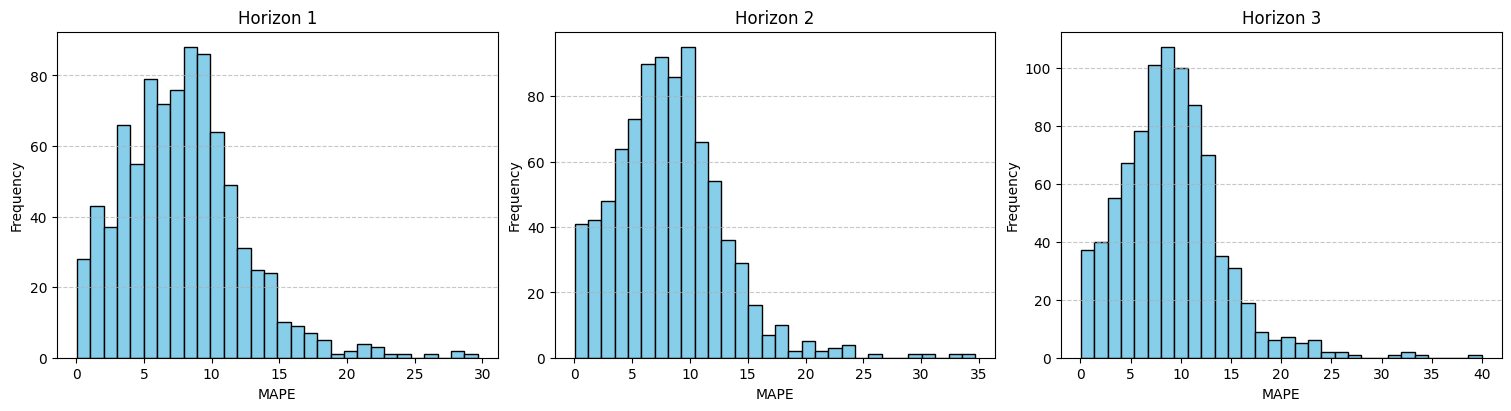

In [ ]:
# @title
fig, axes = plt.subplots(1, len(horizons), figsize=(15, 4), constrained_layout=True)

for i, h in enumerate(horizons):
    ax = axes[i]
    data = GRU_income_exp.loc[GRU_income_exp["horizon"] == h, "mape_model"].dropna()

    ax.hist(data, bins=30, color="skyblue", edgecolor="black")
    ax.set_title(f"Horizon {h}", fontsize=12)
    ax.set_xlabel("MAPE")
    ax.set_ylabel("Frequency")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("mape_hist_GRU_inc_exp.png", dpi=600, bbox_inches="tight")
plt.show()

#### GRU for Income per Capita (only Lagged Target Variable)

In [8]:
# @title
GRU_income_lag = pd.read_csv("https://raw.githubusercontent.com/richardneureuther/DLSS_RNN_Project/main/Data/Final/Results/cbsa_errors_income_GRU_only_lag.csv")
GRU_income_lag["CBSA_Code"] = GRU_income_exp["CBSA_Code"].astype(str)
GRU_income_lag["mape_model"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).to_frame().T.round(2)

,count,mean,std,min,5%,25%,50%,75%,95%,max
mape_model,2610.0,2.79,2.97,0.0,0.18,0.87,1.98,3.69,8.37,27.87


In [9]:
# @title
#drop Hawaii and Alaska and merge with shapefile
GRU_income_lag = GRU_income_lag[~GRU_income_lag["CBSA_Code"].astype(str).isin(drop_cbsa_codes)]

merged_lag = cbsa_shapes.merge(GRU_income_lag, left_on="GEOID", right_on="CBSA_Code")

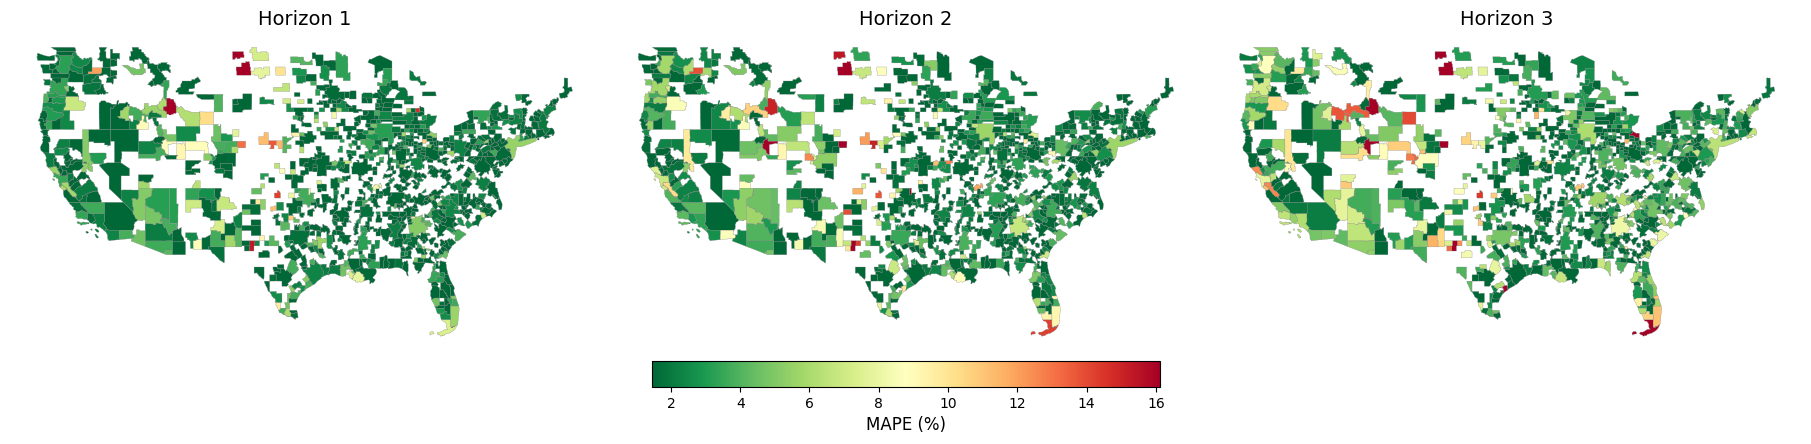

In [ ]:
# @title
# Get global vmin/vmax for consistent scale across horizons
vmin = merged["mape_model"].quantile(0.05)
vmax = merged["mape_model"].quantile(0.95)

# Plot
fig, axes = plt.subplots(1, len(horizons), figsize=(18, 6), constrained_layout=True)

for i, h in enumerate(horizons):
    ax = axes[i]
    merged_lag[merged_lag["horizon"] == h].plot(
        column="mape_model",
        cmap="RdYlGn_r",
        linewidth=0.2,
        edgecolor="grey",
        legend=False,
        ax=ax,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"Horizon {h}", fontsize=14)
    ax.axis("off")

# Shared colorbar
sm = plt.cm.ScalarMappable(cmap="RdYlGn_r", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=axes, orientation="horizontal", fraction=0.05, pad=0.02)
cbar.set_label("MAPE (%)", fontsize=12)

# Save high-res image
plt.savefig("mape_maps_GRU_income_lag.png", dpi=600, bbox_inches="tight")
plt.show()


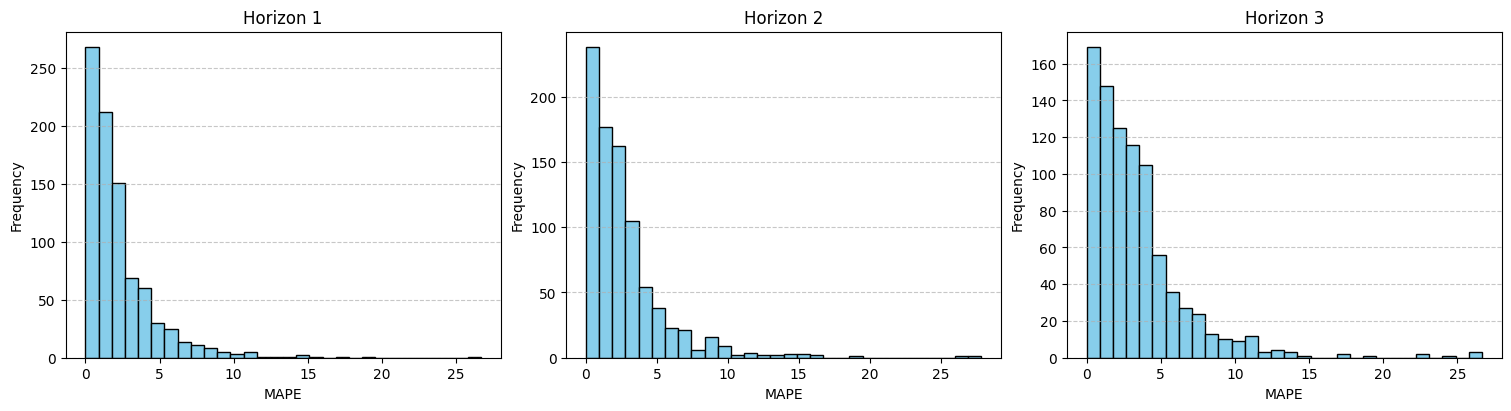

In [ ]:
# @title
fig, axes = plt.subplots(1, len(horizons), figsize=(15, 4), constrained_layout=True)

for i, h in enumerate(horizons):
    ax = axes[i]
    data = GRU_income_lag.loc[GRU_income_lag["horizon"] == h, "mape_model"].dropna()

    ax.hist(data, bins=30, color="skyblue", edgecolor="black")
    ax.set_title(f"Horizon {h}", fontsize=12)
    ax.set_xlabel("MAPE")
    ax.set_ylabel("Frequency")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("mape_hist_GRU_inc_lag.png", dpi=600, bbox_inches="tight")
plt.show()

#### LSTM for Job Creation by Firm Births (only Expenditure)

In [12]:
# @title
LSTM_jobcreation_exp = pd.read_csv("https://raw.githubusercontent.com/richardneureuther/DLSS_RNN_Project/main/Data/Final/Results/cbsa_errors_jobcreation_LSTM_only_expenditure.csv")
LSTM_jobcreation_exp["CBSA_Code"] = LSTM_jobcreation_exp["CBSA_Code"].astype(str)
LSTM_jobcreation_exp["smape_model"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).to_frame().T.round(2)

,count,mean,std,min,5%,25%,50%,75%,95%,max
smape_model,2760.0,27.24,23.11,0.0,2.04,9.82,21.4,38.23,72.56,170.9


In [13]:
# @title
#drop Hawaii and Alaska and merge with shapefile
LSTM_jobcreation_exp = LSTM_jobcreation_exp[~LSTM_jobcreation_exp["CBSA_Code"].astype(str).isin(drop_cbsa_codes)]

LSTM_jc_merged_exp = cbsa_shapes.merge(LSTM_jobcreation_exp, left_on="GEOID", right_on="CBSA_Code")

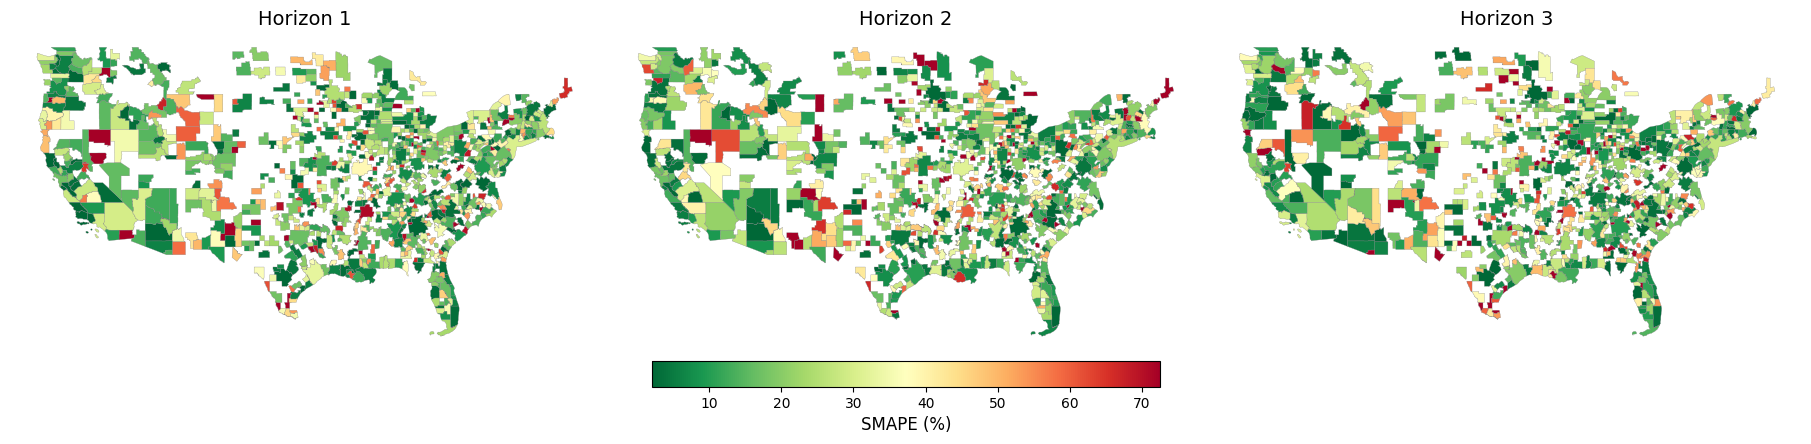

In [ ]:
# @title
# Get global vmin/vmax for consistent scale across horizons
vmin = LSTM_jc_merged_exp["smape_model"].quantile(0.05)
vmax = LSTM_jc_merged_exp["smape_model"].quantile(0.95)

# Plot
fig, axes = plt.subplots(1, len(horizons), figsize=(18, 6), constrained_layout=True)

for i, h in enumerate(horizons):
    ax = axes[i]
    LSTM_jc_merged_exp[LSTM_jc_merged_exp["horizon"] == h].plot(
        column="smape_model",
        cmap="RdYlGn_r",
        linewidth=0.2,
        edgecolor="grey",
        legend=False,
        ax=ax,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"Horizon {h}", fontsize=14)
    ax.axis("off")

# Shared colorbar
sm = plt.cm.ScalarMappable(cmap="RdYlGn_r", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=axes, orientation="horizontal", fraction=0.05, pad=0.02)
cbar.set_label("SMAPE (%)", fontsize=12)

# Save high-res image
plt.savefig("smape_maps_LSTM_jc_exp.png", dpi=600, bbox_inches="tight")
plt.show()


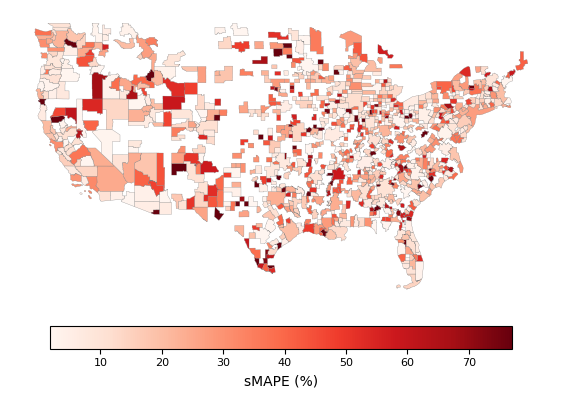

In [21]:
# @title
# Horizon 3 only for REPORT
h = 3

# Filter data
subset_h3_jc = LSTM_jc_merged_exp[LSTM_jc_merged_exp["horizon"] == h]

# vmin/vmax based on horizon 3 MAPE percentiles
vmin_h3 = subset_h3_jc["smape_model"].quantile(0.05)
vmax_h3 = subset_h3_jc["smape_model"].quantile(0.95)

# Plot
fig, ax = plt.subplots(figsize=(7, 6))

subset_h3_jc.plot(
    column="smape_model",
    cmap="Reds",
    linewidth=0.2,
    edgecolor="grey",
    legend=False,
    ax=ax,
    vmin=vmin_h3,
    vmax=vmax_h3
)
ax.axis("off")

# Add horizontal colorbar below
sm = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=vmin_h3, vmax=vmax_h3))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.05, pad=0.05)
cbar.set_label("sMAPE (%)", fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Save high-res
plt.savefig("smape_map_horizon3_LSTM_jc_reds.png", dpi=600, bbox_inches="tight")
plt.show()


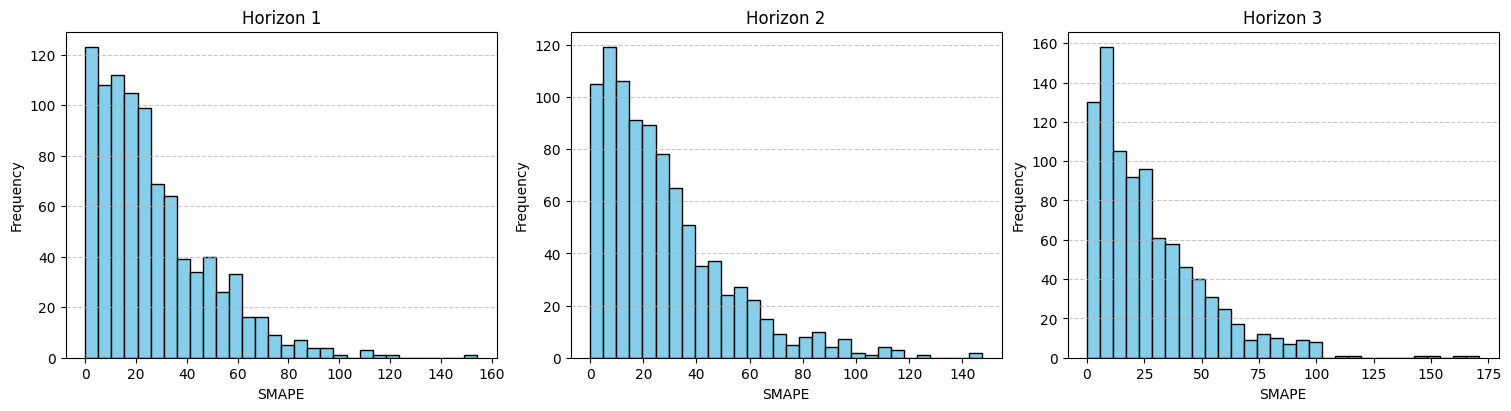

In [ ]:
# @title
fig, axes = plt.subplots(1, len(horizons), figsize=(15, 4), constrained_layout=True)

for i, h in enumerate(horizons):
    ax = axes[i]
    data = LSTM_jobcreation_exp.loc[LSTM_jobcreation_exp["horizon"] == h, "smape_model"].dropna()

    ax.hist(data, bins=30, color="skyblue", edgecolor="black")
    ax.set_title(f"Horizon {h}", fontsize=12)
    ax.set_xlabel("SMAPE")
    ax.set_ylabel("Frequency")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("smape_hist_LSTM_jc_exp.png", dpi=600, bbox_inches="tight")
plt.show()

#### LSTM for Job Creation by Firm Births (only Lagged Target Variable)

In [ ]:
# @title
LSTM_jobcreation_lag = pd.read_csv("https://raw.githubusercontent.com/richardneureuther/DLSS_RNN_Project/main/Data/Final/Results/cbsa_errors_jobcreation_LSTM_only_lag.csv")
LSTM_jobcreation_lag["CBSA_Code"] = LSTM_jobcreation_lag["CBSA_Code"].astype(str)
LSTM_jobcreation_lag["smape_model"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).to_frame().T.round(2)

,count,mean,std,min,5%,25%,50%,75%,95%,max
smape_model,2760.0,28.42,23.18,0.04,2.26,11.14,23.07,39.47,74.17,163.47


In [ ]:
# @title
#drop Hawaii and Alaska and merge with shapefile
LSTM_jobcreation_lag = LSTM_jobcreation_lag[~LSTM_jobcreation_exp["CBSA_Code"].astype(str).isin(drop_cbsa_codes)]

LSTM_jc_merged_lag = cbsa_shapes.merge(LSTM_jobcreation_lag, left_on="GEOID", right_on="CBSA_Code")

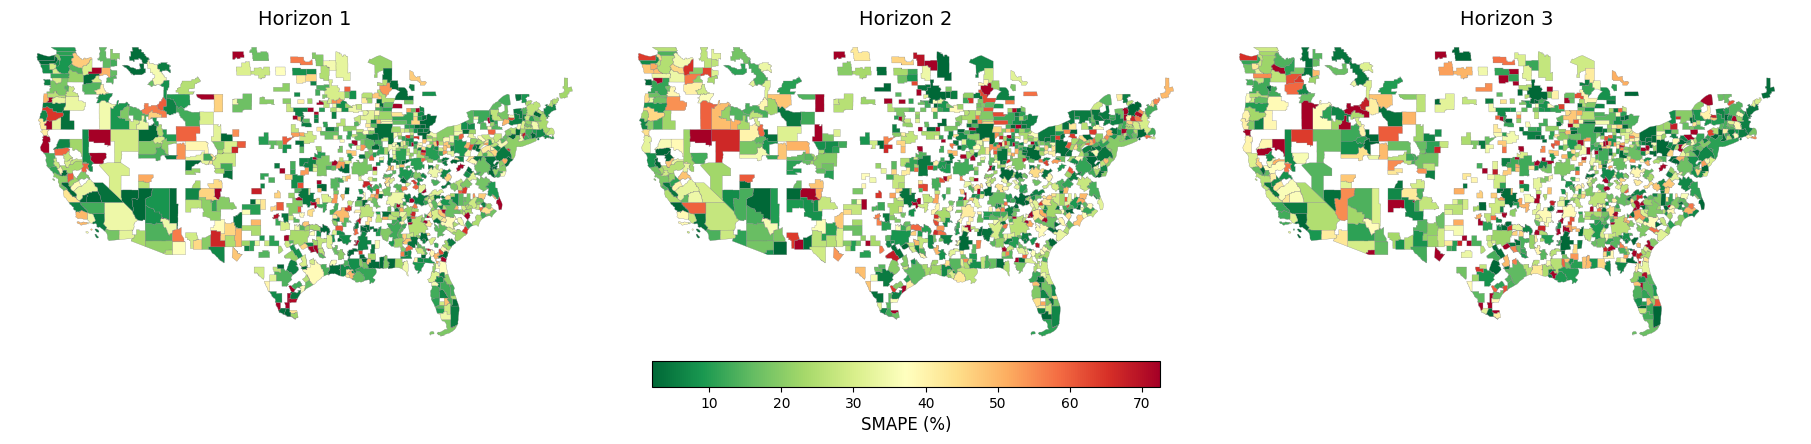

In [ ]:
# @title
# Get global vmin/vmax for consistent scale across horizons
vmin = LSTM_jc_merged_exp["smape_model"].quantile(0.05)
vmax = LSTM_jc_merged_exp["smape_model"].quantile(0.95)

# Plot
fig, axes = plt.subplots(1, len(horizons), figsize=(18, 6), constrained_layout=True)

for i, h in enumerate(horizons):
    ax = axes[i]
    LSTM_jc_merged_lag[LSTM_jc_merged_lag["horizon"] == h].plot(
        column="smape_model",
        cmap="RdYlGn_r",
        linewidth=0.2,
        edgecolor="grey",
        legend=False,
        ax=ax,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"Horizon {h}", fontsize=14)
    ax.axis("off")

# Shared colorbar
sm = plt.cm.ScalarMappable(cmap="RdYlGn_r", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=axes, orientation="horizontal", fraction=0.05, pad=0.02)
cbar.set_label("SMAPE (%)", fontsize=12)

# Save high-res image
plt.savefig("smape_maps_LSTM_jc_lag.png", dpi=600, bbox_inches="tight")
plt.show()


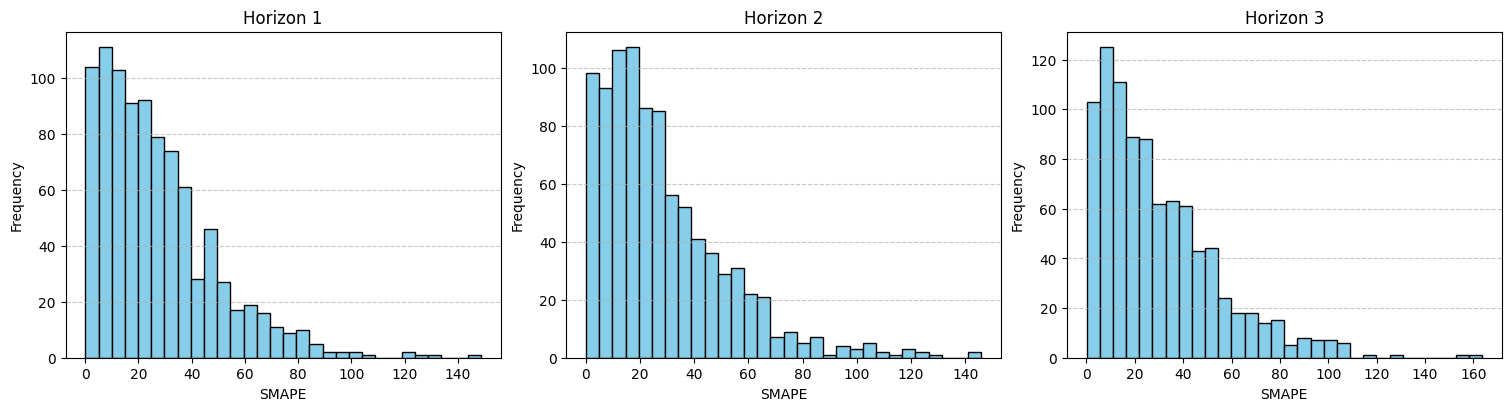

In [ ]:
# @title
fig, axes = plt.subplots(1, len(horizons), figsize=(15, 4), constrained_layout=True)

for i, h in enumerate(horizons):
    ax = axes[i]
    data = LSTM_jobcreation_lag.loc[LSTM_jobcreation_lag["horizon"] == h, "smape_model"].dropna()

    ax.hist(data, bins=30, color="skyblue", edgecolor="black")
    ax.set_title(f"Horizon {h}", fontsize=12)
    ax.set_xlabel("SMAPE")
    ax.set_ylabel("Frequency")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("smape_hist_LSTM_jc_lag.png", dpi=600, bbox_inches="tight")
plt.show()